# 1. Text Classification

## 3.1 Text Preprocessing, Tokenization, and Sequence Padding:

### 3.1.1 Load the dataset:

In [ ]:
# Install required packages
!pip install contractions
!pip install gensim
!pip install wordcloud
!pip install gradio
!pip install imblearn

In [ ]:
# Mounting drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import re
import contractions
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
import gradio as gr
import gensim.downloader as api
from imblearn.over_sampling import RandomOverSampler

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
# Loading the dataset
df = pd.read_csv('/content/drive/MyDrive/RNN/Hotel_Reviews.csv')

In [ ]:
# Display basic info
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
display(df.head())

Dataset shape: (20491, 2)

First 5 rows:


,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [ ]:
np.sort(df['Rating'].unique())

array([1, 2, 3, 4, 5])

In [ ]:
#Checking the dtypes of all the columns

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [ ]:
df['Rating'].value_counts()

,count
Rating,
5,9054
4,6039
3,2184
2,1793
1,1421


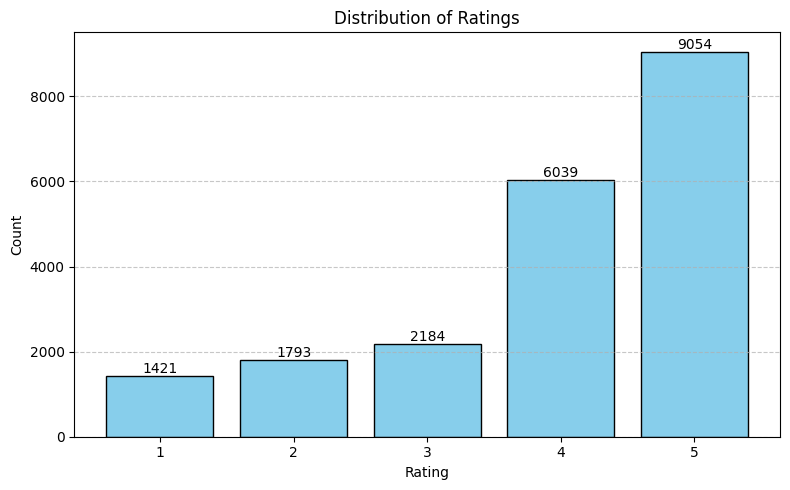

In [ ]:
import matplotlib.pyplot as plt

# Count the occurrences of each rating
rating_counts = df["Rating"].value_counts().sort_index()

# Create a bar plot
plt.figure(figsize=(8, 5))
bars = plt.bar(rating_counts.index.astype(str), rating_counts.values, color='skyblue', edgecolor='black')

# Add value labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval), ha='center', va='bottom')

plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Distribution of Ratings")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
#checking null value
df.isna().sum()

,0
Review,0
Rating,0


In [ ]:
# Length of word in sentence
df['Length'] = df['Review'].apply(len)
df.head()

,Review,Rating,Length
0,nice hotel expensive parking got good deal sta...,4,593
1,ok nothing special charge diamond member hilto...,2,1689
2,nice rooms not 4* experience hotel monaco seat...,3,1427
3,"unique, great stay, wonderful time hotel monac...",5,600
4,"great stay great stay, went seahawk game aweso...",5,1281


In [ ]:
# Find the maximum length of text in the 'Review' column
longest_review_length = df['Review'].str.len().max()

# Print the maximum length
print(f"The maximum length of text in the 'Review' column is: {longest_review_length}")



The maximum length of text in the 'Review' column is: 13501


In [ ]:
# any duplicate data
df.duplicated().sum()

0

### 3.2 Data pre processing

In [ ]:
# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [ ]:
def preprocess_text(raw_review_text):
    # Lowercase
    raw_review_text = raw_review_text.lower()

    # Remove URLs
    raw_review_text = re.sub(r'http\S+|www\S+|https\S+', '', raw_review_text, flags=re.MULTILINE)

    # Remove mentions and hashtags
    raw_review_text = re.sub(r'@\w+|\#\w+', '', raw_review_text)

    # Remove numbers and special characters
    raw_review_text = re.sub(r'[^a-zA-Z\s]', '', raw_review_text)

    # Handle contractions
    raw_review_text = contractions.fix(raw_review_text)

    # Remove stopwords and lemmatize, retain sentiment stopwords
    tokens = raw_review_text.split()
    sentiment_stopwords = {'not', 'very', 'really', 'quite', 'too', 'so', 'bad', 'poor', 'great', 'good', 'never', 'terrible', 'excellent', 'horrible', 'awful'}
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words or word in sentiment_stopwords]

    return ' '.join(tokens)


In [ ]:
# Preprocess the reviews
df['cleaned_review'] = df['Review'].apply(preprocess_text)

In [ ]:
# Check for empty reviews
print("\nEmpty cleaned reviews:", sum(df['cleaned_review'] == ''))


Empty cleaned reviews: 0


Generating word cloud for cleaned training data...


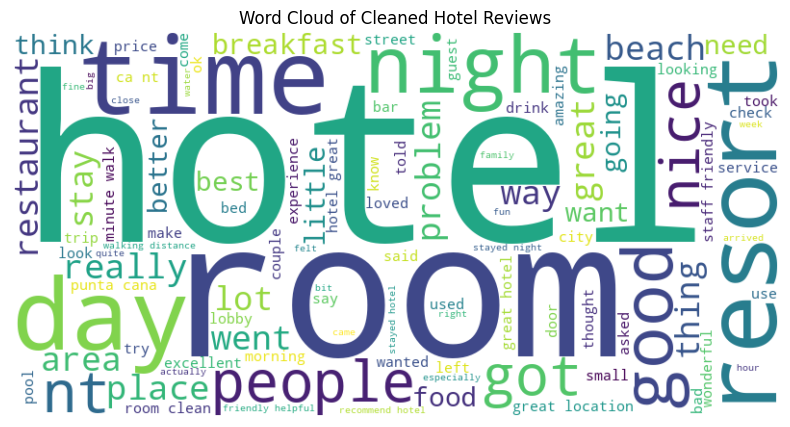

In [ ]:
print("Generating word cloud for cleaned training data...")
cleaned_text_corpus = ' '.join(df['cleaned_review'])
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100, random_state=42).generate(cleaned_text_corpus)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Cleaned Hotel Reviews')
plt.savefig('word_cloud.png')
plt.show()

Generating bar plot of most frequent words...


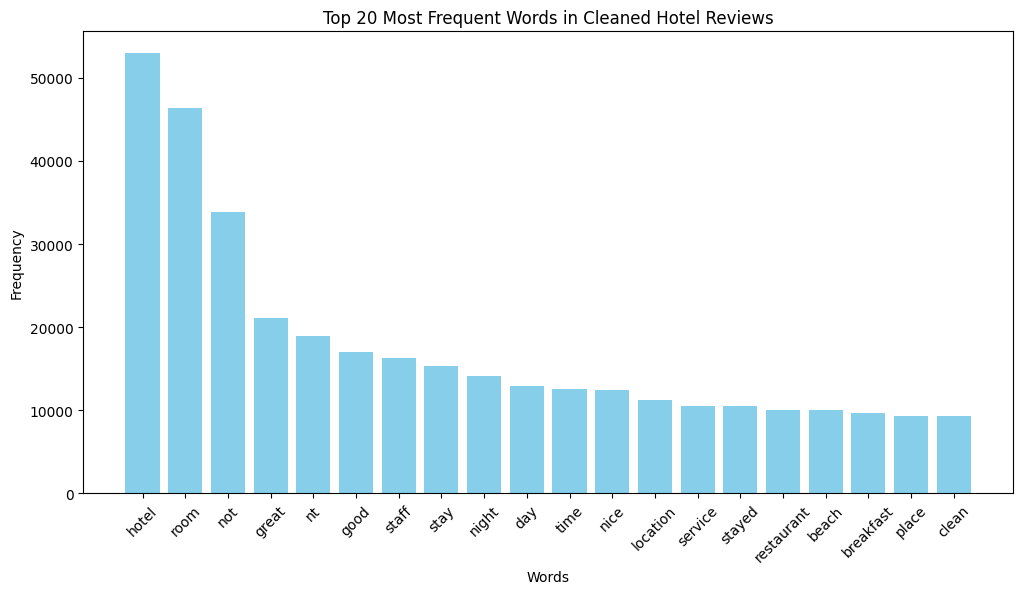

In [ ]:
print("Generating bar plot of most frequent words...")
token_list = cleaned_text_corpus.split()
word_counts = Counter(token_list)
most_common_words = word_counts.most_common(20)
top_words, counts = zip(*most_common_words)
plt.figure(figsize=(12, 6))
plt.bar(top_words, counts, color='skyblue')
plt.title('Top 20 Most Frequent Words in Cleaned Hotel Reviews')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.savefig('frequent_words.png')
plt.show()


In [ ]:
df.head()

,Review,Rating,Length,cleaned_review
0,nice hotel expensive parking got good deal sta...,4,593,nice hotel expensive parking got good deal sta...
1,ok nothing special charge diamond member hilto...,2,1689,ok nothing special charge diamond member hilto...
2,nice rooms not 4* experience hotel monaco seat...,3,1427,nice room not experience hotel monaco seattle ...
3,"unique, great stay, wonderful time hotel monac...",5,600,unique great stay wonderful time hotel monaco ...
4,"great stay great stay, went seahawk game aweso...",5,1281,great stay great stay went seahawk game awesom...


In [ ]:
# Split dataset
X = df['cleaned_review']
y = df['Rating'] - 1  # Adjust ratings to 0-4 for one-hot encoding
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Oversample minority classes (ratings 1, 2, 3) on training data
ros = RandomOverSampler(sampling_strategy={0: 4000, 1: 4000, 2: 4000}, random_state=42)  # Match minority to majority class count
resampled_train_features, resampled_train_labels = ros.fit_resample(X_train.to_frame(), y_train)
resampled_train_features = resampled_train_features['cleaned_review']  # Convert back to Series


In [ ]:
# Check new training distribution
print("\nNew Training Distribution after Oversampling:")
print(pd.Series(resampled_train_labels).value_counts())



New Training Distribution after Oversampling:
Rating
4    7243
3    4831
1    4000
2    4000
0    4000
Name: count, dtype: int64


In [ ]:
# Tokenize text
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(resampled_train_features)  # Fit on resampled training data

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(resampled_train_features)  # Use resampled data
test_sequences = tokenizer.texts_to_sequences(X_test)

# Calculate 95th percentile length for padding
train_seq_lengths = [len(seq) for seq in train_sequences]
max_len = int(np.percentile(train_seq_lengths, 95))
print(f"Using sequence length of {max_len} (95th percentile)")

# Pad sequences
train_padded_sequences = pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')
test_padded_sequences = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

# Convert labels to one-hot encoding
num_classes = 5
train_labels_one_hot = tf.keras.utils.to_categorical(resampled_train_labels, num_classes)  # Use resampled labels
test_labels_one_hot = tf.keras.utils.to_categorical(y_test, num_classes)


Using sequence length of 274 (95th percentile)


In [ ]:
# Compute class weights for imbalance, including class 3
computed_class_weights = compute_class_weight('balanced', classes=np.unique(resampled_train_labels), y=resampled_train_labels)
adjusted_class_weights = dict(enumerate(computed_class_weights))

# Adjust weights to reduce overemphasis on minority classes 0, 1, and 2
adjusted_class_weights[0] *= 0.8  # Rating 1
adjusted_class_weights[1] *= 0.8  # Rating 2
adjusted_class_weights[2] *= 0.8  # Rating 3

print("\nAdjusted Class Weights:", adjusted_class_weights)



Adjusted Class Weights: {0: 0.96296, 1: 0.96296, 2: 0.96296, 3: 0.9966466570068309, 4: 0.6647521745133232}


In [ ]:
# Load pretrained Word2Vec embeddings for Model 3
print("Loading Word2Vec embeddings...")

word2vec_embeddings = api.load('word2vec-google-news-300')
word2vec_embedding_dim = 300


Loading Word2Vec embeddings...
[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
# Create embedding matrix
tokenizer_vocab_size = len(tokenizer.word_index) + 1
word_embeddings_matrix = np.zeros((tokenizer_vocab_size, word2vec_embedding_dim))

for token, token_index in tokenizer.word_index.items():
    if token_index < tokenizer_vocab_size and token in word2vec_embeddings:
        word_embeddings_matrix[token_index] = word2vec_embeddings[token]


In [ ]:
rnn_model = Sequential([
    Embedding(input_dim=tokenizer_vocab_size, output_dim=word2vec_embedding_dim),  # Removed input_length
    Bidirectional(SimpleRNN(32, return_sequences=False, kernel_regularizer=l2(0.01))),  # Reduced units, added L2
    Dropout(0.5),  # Increased dropout
    Dense(num_classes, activation='softmax')  # Use num_classes
])

rnn_model.compile(optimizer=Adam(learning_rate=0.0003, clipnorm=1.0),  # Lower learning rate
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])


In [ ]:
# Model 2: Bidirectional LSTM with reduced complexity and regularization
rnn_model2 = Sequential([
    Embedding(input_dim=tokenizer_vocab_size, output_dim=word2vec_embedding_dim, input_length=max_len),  # Updated variables
    Bidirectional(LSTM(32, return_sequences=False, kernel_regularizer=l2(0.01))),  # Reduced units, added L2
    Dropout(0.5),  # Increased dropout
    Dense(num_classes, activation='softmax')  # Updated variable
])

rnn_model2.compile(optimizer=Adam(learning_rate=0.0003, clipnorm=1.0),  # Lower learning rate
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])


In [ ]:
# Model 3: Bidirectional LSTM with Word2Vec, reduced complexity
model3 = Sequential([
    Embedding(input_dim=tokenizer_vocab_size, output_dim=word2vec_embedding_dim, weights=[word_embeddings_matrix], input_length=max_len, trainable=True),
    Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01))),  # Reduced units, added L2
    Bidirectional(LSTM(32, return_sequences=False, kernel_regularizer=l2(0.01))),  # Reduced units, added L2
    Dropout(0.5),  # Increased dropout
    Dense(num_classes, activation='softmax')  # Use num_classes for output layer
])

model3.compile(optimizer=Adam(learning_rate=0.00005, clipnorm=1.0),  # Further reduced learning rate
               loss='categorical_crossentropy',
               metrics=['accuracy'])

In [ ]:
# Training function
def train_model(model, train_padded_sequences, train_labels_one_hot, test_padded_sequences, test_labels_one_hot, model_name, epochs=20):
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

    # Fit the model
    history = model.fit(
        train_padded_sequences, train_labels_one_hot,
        epochs=epochs,
        batch_size=32,
        validation_data=(test_padded_sequences, test_labels_one_hot),
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    # Plot accuracy and loss
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'{model_name}_training_plot.png')
    plt.show()

    return history


Training Model 1 (SimpleRNN)...
Epoch 1/20
753/753 ━━━━━━━━━━━━━━━━━━━━ 45s 51ms/step - accuracy: 0.3765 - loss: 2.1991 - val_accuracy: 0.5260 - val_loss: 1.2701 - learning_rate: 3.0000e-04
Epoch 2/20
753/753 ━━━━━━━━━━━━━━━━━━━━ 35s 46ms/step - accuracy: 0.6524 - loss: 1.0859 - val_accuracy: 0.5677 - val_loss: 1.0752 - learning_rate: 3.0000e-04
Epoch 3/20
753/753 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - accuracy: 0.7753 - loss: 0.7158 - val_accuracy: 0.5745 - val_loss: 1.0884 - learning_rate: 3.0000e-04
Epoch 4/20
753/753 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - accuracy: 0.8277 - loss: 0.5406 - val_accuracy: 0.5631 - val_loss: 1.1134 - learning_rate: 3.0000e-04
Epoch 5/20
753/753 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - accuracy: 0.8661 - loss: 0.4342 - val_accuracy: 0.5660 - val_loss: 1.1575 - learning_rate: 1.5000e-04


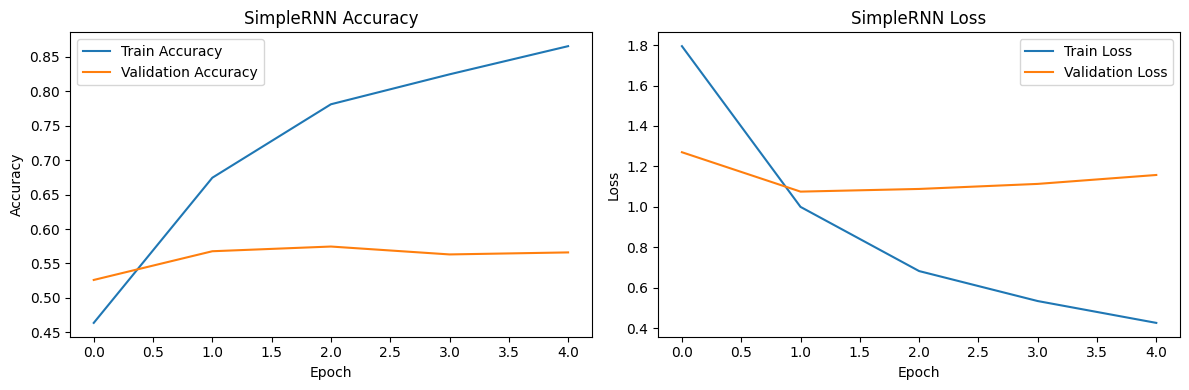

In [ ]:
# Train models
print("Training Model 1 (SimpleRNN)...")
history1 = train_model(rnn_model, train_padded_sequences, train_labels_one_hot, test_padded_sequences, test_labels_one_hot, "SimpleRNN")



Training Model 2 (LSTM)...
Epoch 1/20
753/753 ━━━━━━━━━━━━━━━━━━━━ 31s 33ms/step - accuracy: 0.3764 - loss: 2.8695 - val_accuracy: 0.5679 - val_loss: 1.0044 - learning_rate: 3.0000e-04
Epoch 2/20
753/753 ━━━━━━━━━━━━━━━━━━━━ 38s 32ms/step - accuracy: 0.6085 - loss: 0.9747 - val_accuracy: 0.5792 - val_loss: 0.9761 - learning_rate: 3.0000e-04
Epoch 3/20
753/753 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.7044 - loss: 0.7909 - val_accuracy: 0.5887 - val_loss: 0.9908 - learning_rate: 3.0000e-04
Epoch 4/20
753/753 ━━━━━━━━━━━━━━━━━━━━ 24s 32ms/step - accuracy: 0.7526 - loss: 0.6886 - val_accuracy: 0.5706 - val_loss: 1.0325 - learning_rate: 3.0000e-04
Epoch 5/20
753/753 ━━━━━━━━━━━━━━━━━━━━ 24s 32ms/step - accuracy: 0.7917 - loss: 0.6026 - val_accuracy: 0.5828 - val_loss: 1.0758 - learning_rate: 1.5000e-04


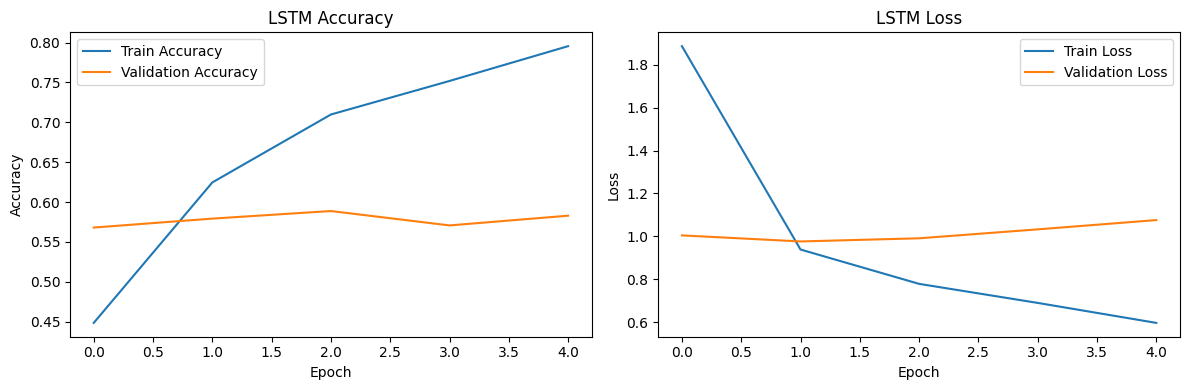

In [ ]:
# Train models
print("\nTraining Model 2 (LSTM)...")
history2 = train_model(rnn_model2, train_padded_sequences, train_labels_one_hot, test_padded_sequences, test_labels_one_hot, "LSTM")



Training Model 3 (LSTM with Word2Vec)...
Epoch 1/20
753/753 ━━━━━━━━━━━━━━━━━━━━ 43s 51ms/step - accuracy: 0.2955 - loss: 8.0832 - val_accuracy: 0.5004 - val_loss: 4.3610 - learning_rate: 5.0000e-05
Epoch 2/20
753/753 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - accuracy: 0.5092 - loss: 3.8295 - val_accuracy: 0.5628 - val_loss: 2.4603 - learning_rate: 5.0000e-05
Epoch 3/20
753/753 ━━━━━━━━━━━━━━━━━━━━ 41s 51ms/step - accuracy: 0.5709 - loss: 2.2599 - val_accuracy: 0.5845 - val_loss: 1.6847 - learning_rate: 5.0000e-05
Epoch 4/20
753/753 ━━━━━━━━━━━━━━━━━━━━ 40s 50ms/step - accuracy: 0.6124 - loss: 1.5894 - val_accuracy: 0.5779 - val_loss: 1.4098 - learning_rate: 5.0000e-05
Epoch 5/20
753/753 ━━━━━━━━━━━━━━━━━━━━ 46s 56ms/step - accuracy: 0.6667 - loss: 1.2794 - val_accuracy: 0.6109 - val_loss: 1.2462 - learning_rate: 5.0000e-05
Epoch 6/20
753/753 ━━━━━━━━━━━━━━━━━━━━ 78s 51ms/step - accuracy: 0.7038 - loss: 1.1268 - val_accuracy: 0.5953 - val_loss: 1.2317 - learning_rate: 5.0000e-05
Epoch 7/20

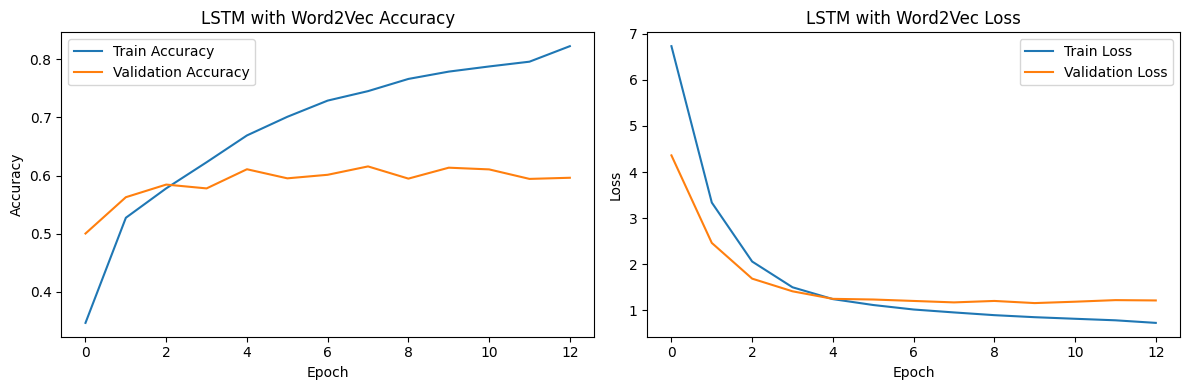

In [ ]:
# Train Model 3
print("\nTraining Model 3 (LSTM with Word2Vec)...")
history3 = train_model(model3, train_padded_sequences, train_labels_one_hot, test_padded_sequences, test_labels_one_hot, "LSTM with Word2Vec")


In [ ]:
# Evaluation function
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

    acc = accuracy_score(y_test_classes, y_pred_classes)
    print(f"\n{model_name} Evaluation:")
    print("Accuracy:", acc)
    print("\nClassification Report:")
    print(classification_report(y_test_classes, y_pred_classes, target_names=['1', '2', '3', '4', '5']))

    cm = confusion_matrix(y_test_classes, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['1', '2', '3', '4', '5'], yticklabels=['1', '2', '3', '4', '5'])
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.savefig(f'{model_name}_confusion_matrix.png')
    plt.show()

    return acc


129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step

SimpleRNN Evaluation:
Accuracy: 0.5676994388875335

Classification Report:
              precision    recall  f1-score   support

           1       0.43      0.65      0.52       284
           2       0.34      0.27      0.30       359
           3       0.31      0.19      0.23       437
           4       0.54      0.24      0.33      1208
           5       0.65      0.93      0.76      1811

    accuracy                           0.57      4099
   macro avg       0.45      0.45      0.43      4099
weighted avg       0.54      0.57      0.52      4099



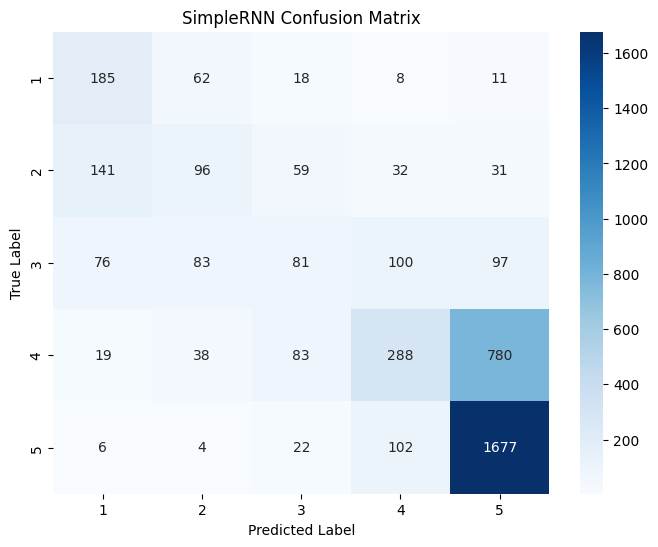

In [ ]:
acc1 = evaluate_model(rnn_model, test_padded_sequences, test_labels_one_hot, "SimpleRNN")


129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step

LSTM Evaluation:
Accuracy: 0.5791656501585752

Classification Report:
              precision    recall  f1-score   support

           1       0.63      0.73      0.68       284
           2       0.38      0.44      0.41       359
           3       0.30      0.41      0.35       437
           4       0.52      0.27      0.36      1208
           5       0.70      0.83      0.76      1811

    accuracy                           0.58      4099
   macro avg       0.51      0.54      0.51      4099
weighted avg       0.57      0.58      0.56      4099



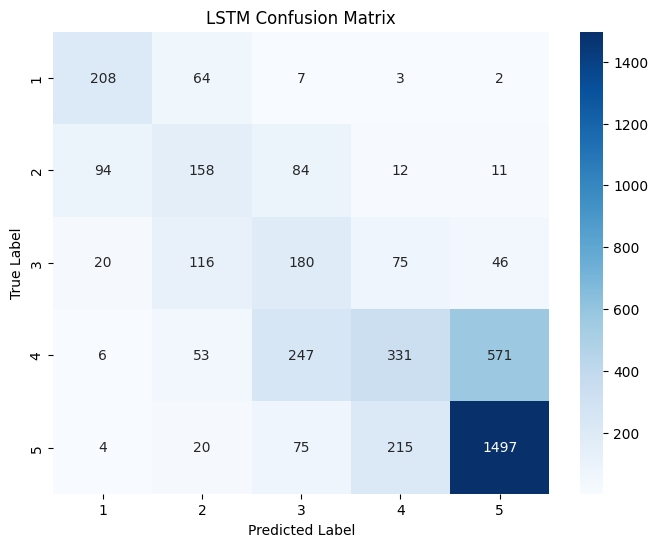

In [ ]:
acc2 = evaluate_model(rnn_model2, test_padded_sequences, test_labels_one_hot, "LSTM")


129/129 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step

LSTM with Word2Vec Evaluation:
Accuracy: 0.6135642839717004

Classification Report:
              precision    recall  f1-score   support

           1       0.68      0.67      0.67       284
           2       0.45      0.41      0.43       359
           3       0.37      0.39      0.38       437
           4       0.52      0.52      0.52      1208
           5       0.76      0.76      0.76      1811

    accuracy                           0.61      4099
   macro avg       0.55      0.55      0.55      4099
weighted avg       0.61      0.61      0.61      4099



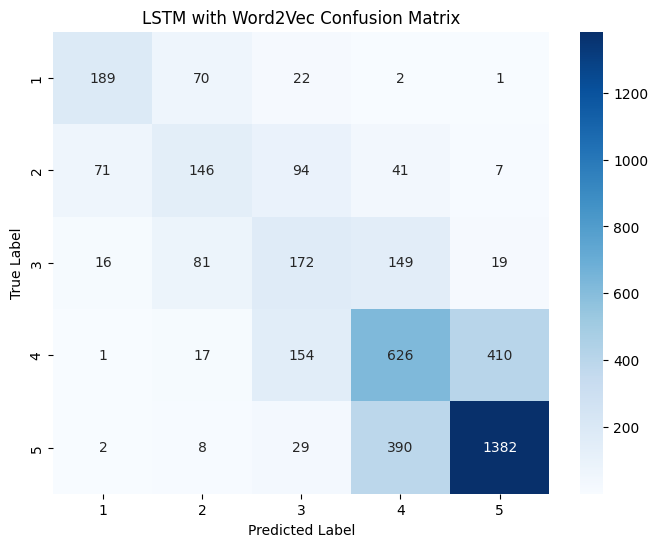

In [ ]:
acc3 = evaluate_model(model3, test_padded_sequences, test_labels_one_hot, "LSTM with Word2Vec")


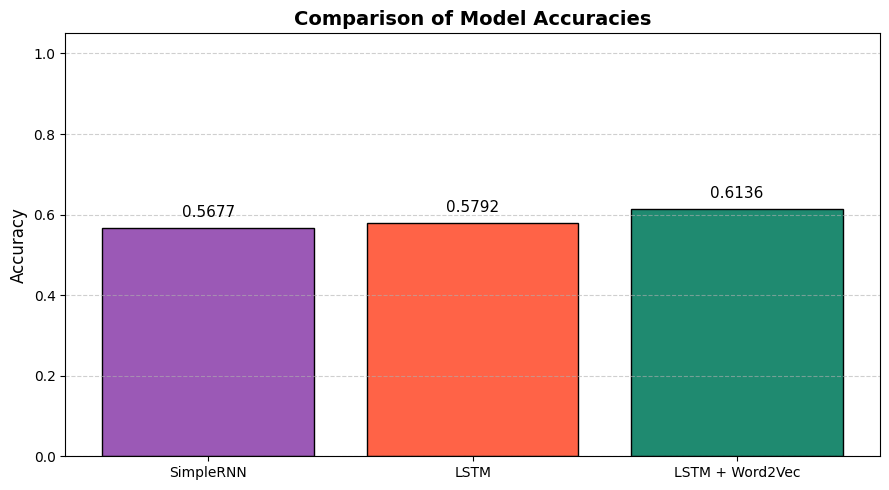

In [ ]:
# Compare model performances with a new vibrant color palette
plt.figure(figsize=(9, 5))

# New vibrant colors
colors = ['#9B59B6', '#FF6347', '#1F8A70']  # purple, coral, teal

bars = plt.bar(['SimpleRNN', 'LSTM', 'LSTM + Word2Vec'], [acc1, acc2, acc3],
               color=colors, edgecolor='black')

plt.title('Comparison of Model Accuracies', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0, 1.05)

# Annotate accuracy values on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.02, f'{height:.4f}',
             ha='center', va='bottom', fontsize=11, fontweight='medium')

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('model_comparison_vibrant.png')
plt.show()


In [ ]:

# Gradio GUI for Real-Time Rating Prediction
def predict_hotel_rating(review_text, selected_model):
    if not review_text.strip():
        return "Please provide a review."

    cleaned_review = preprocess_text(review_text)
    sequence = tokenizer.texts_to_sequences([cleaned_review])
    padded_sequence = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')

    model_options = {
        "SimpleRNN": rnn_model,
        "LSTM": rnn_model2,
        "LSTM with Word2Vec": model3
    }

    if selected_model not in model_options:
        return "The selected model is invalid."

    model = model_options[selected_model]
    prediction = model.predict(padded_sequence, verbose=0)[0]
    predicted_rating = np.argmax(prediction) + 1  # Convert back to 1-5 scale
    confidence_level = np.max(prediction)

    return f"Predicted Rating: {predicted_rating}\nConfidence Level: {confidence_level:.4f}"

In [ ]:
# New GUI Design with gradio
with gr.Blocks(theme=gr.themes.Soft()) as demo:
    gr.Markdown("## Hotel Review Rating Predictor")
    gr.Markdown("Submit a hotel review and choose a model to predict the rating (1-5).")

    # Review Input Section
    with gr.Row():
        review_input = gr.Textbox(label="Hotel Review", placeholder="e.g., The service was fantastic!", lines=3)

    # Model Selection Section
    with gr.Row():
        model_choice = gr.Dropdown(choices=["SimpleRNN", "LSTM", "LSTM with Word2Vec"], label="Select Model", value="LSTM with Word2Vec")

    # Prediction Button and Output Section
    predict_button = gr.Button("Get Prediction")
    output = gr.Textbox(label="Prediction Result", placeholder="The predicted rating will appear here...")

    # Trigger the prediction function when the button is clicked
    predict_button.click(fn=predict_hotel_rating, inputs=[review_input, model_choice], outputs=output)

# Launch the interface
demo.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://4ad40ea0d70cc48d0a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [2]:
!pip install --upgrade \
  pandas \
  numpy \
  matplotlib \
  seaborn \
  wordcloud \
  scikit-learn \
  tensorflow \
  keras \
  gensim \
  nltk \
  contractions \
  gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 114.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 120.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 91.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 117.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322

In [14]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import os
import contractions
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import gradio as gr

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# GloVe embeddings
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
import gensim.downloader as api

# Evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Cell 2: Load & Clean Data
df = pd.read_csv('/content/drive/MyDrive/AL and ML/Hotel_Reviews.csv')[['Review', 'Rating']].dropna()
print("Rating Distribution:\n", df['Rating'].value_counts().sort_index())

Rating Distribution:
 Rating
1    1421
2    1793
3    2184
4    6039
5    9054
Name: count, dtype: int64


In [4]:
# Convert ratings to binary sentiment (1-2: bad(0), 4-5: good(1), remove 3)
df = df[df['Rating'] != 3]
df['Sentiment'] = df['Rating'].apply(lambda x: 0 if x <= 2 else 1)

In [5]:
# Check class distribution
print("Class Distribution:")
print(df['Sentiment'].value_counts())

Class Distribution:
Sentiment
1    15093
0     3214
Name: count, dtype: int64


In [6]:
df.head()

,Review,Rating,Sentiment
0,nice hotel expensive parking got good deal sta...,4,1
1,ok nothing special charge diamond member hilto...,2,0
3,"unique, great stay, wonderful time hotel monac...",5,1
4,"great stay great stay, went seahawk game aweso...",5,1
5,love monaco staff husband stayed hotel crazy w...,5,1


In [37]:
df.isnull().any()

,0
Review,False
Rating,False
Sentiment,False


In [7]:
# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Convert to lowercase
    text = text.lower()

    # Expand contractions
    text = contractions.fix(text)

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove user mentions and hashtags
    text = re.sub(r'@\w+|\#\w+', '', text)

    # Remove numbers and special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenize and remove stopwords
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return ' '.join(tokens)

In [8]:
# Split into train and test
X = df['Review']
y = df['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Clean text
X_train_clean = X_train.apply(clean_text)
X_test_clean = X_test.apply(clean_text)

Generating word cloud for cleaned training data...


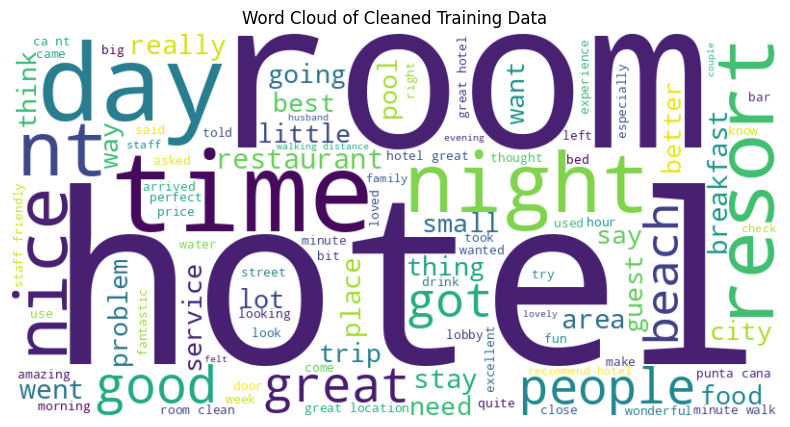

In [38]:
print("Generating word cloud for cleaned training data...")
all_text = ' '.join(X_train_clean)
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100, random_state=42).generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Cleaned Training Data')
plt.show()

Generating bar plot of most frequent words...


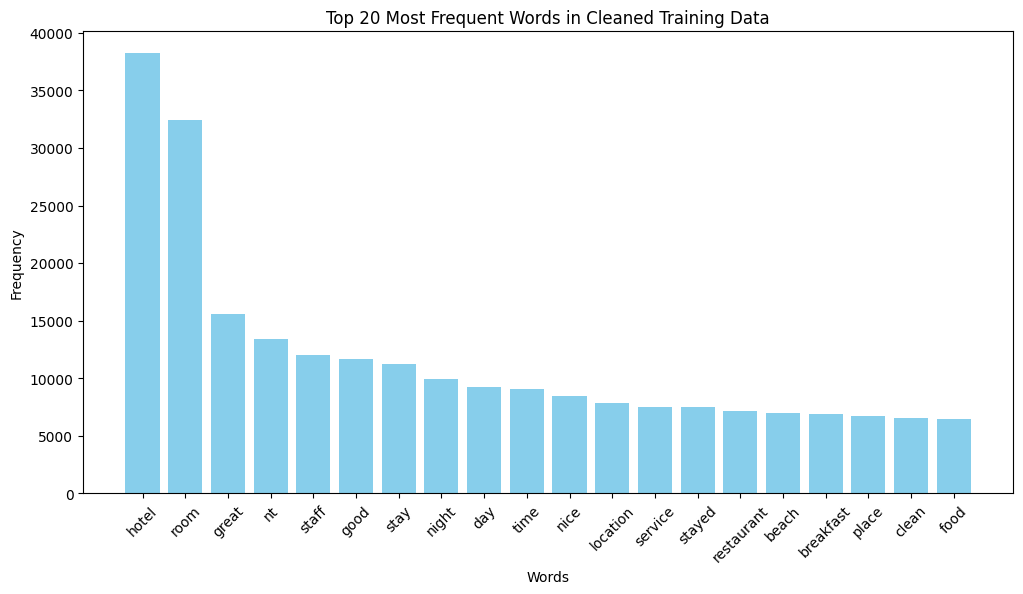

In [39]:
print("Generating bar plot of most frequent words...")
words = all_text.split()
word_counts = Counter(words)
most_common_words = word_counts.most_common(20)  # Top 20 words
words, counts = zip(*most_common_words)

plt.figure(figsize=(12, 6))
plt.bar(words, counts, color='skyblue')
plt.title('Top 20 Most Frequent Words in Cleaned Training Data')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [9]:
# Tokenization
max_words = 10000
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train_clean)

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train_clean)
X_test_seq = tokenizer.texts_to_sequences(X_test_clean)

# Calculate sequence lengths to determine padding length (95th percentile)
train_seq_lengths = [len(seq) for seq in X_train_seq]
percentile_95 = np.percentile(train_seq_lengths, 95)
max_len = int(percentile_95)
print(f"Using sequence length of {max_len} (95th percentile)")

# Pad the sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

# Validate data shapes
print(f"X_train_pad shape: {X_train_pad.shape}, y_train shape: {y_train.shape}")
print(f"X_test_pad shape: {X_test_pad.shape}, y_test shape: {y_test.shape}")
print("Test class distribution:", np.unique(y_test, return_counts=True))

Using sequence length of 254 (95th percentile)
X_train_pad shape: (14645, 254), y_train shape: (14645,)
X_test_pad shape: (3662, 254), y_test shape: (3662,)
Test class distribution: (array([0, 1]), array([ 643, 3019]))


In [10]:
# Apply SMOTE to the padded sequences
print("\nBefore SMOTE class distribution:", np.unique(y_train, return_counts=True))


Before SMOTE class distribution: (array([0, 1]), array([ 2571, 12074]))


In [11]:
# Reshape for SMOTE (temporarily flatten the sequences)
n_samples, n_timesteps = X_train_pad.shape
X_train_flat = X_train_pad.reshape(n_samples, -1)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled_flat, y_train_resampled = smote.fit_resample(X_train_flat, y_train)

# Reshape back to original dimensions
X_train_resampled = X_train_resampled_flat.reshape(-1, n_timesteps)

print("After SMOTE class distribution:", np.unique(y_train_resampled, return_counts=True))

After SMOTE class distribution: (array([0, 1]), array([12074, 12074]))


In [15]:
# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print("Class weights:", class_weight_dict)

Class weights: {0: 1.0, 1: 1.0}


In [16]:
# Model 1: Simple RNN
embedding_dim = 128

# Model 1: Simple RNN (Trainable Embedding)
model1 = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
    SimpleRNN(64, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Sigmoid activation, no extra Dense layer
])

model1.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [17]:
# Model 2: LSTM (Trainable Embedding)
model2 = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Sigmoid activation, no extra Dense layer
])

model2.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [21]:
def train_model(model, X_train, y_train, X_val, y_val, model_name, epochs=30):
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

    try:
        print(f"Training {model_name} with input shapes: X_train={X_train.shape}, y_train={y_train.shape}, X_val={X_val.shape}, y_val={y_val.shape}")
        history = model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=64,
            validation_data=(X_val, y_val),
            callbacks=[early_stopping, reduce_lr],
            class_weight=class_weight_dict,
            verbose=1
        )

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'{model_name} Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'{model_name} Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()

        return history
    except Exception as e:
        print(f"Error training {model_name}: {str(e)}")
        return None

Training Model 1 (SimpleRNN)...
Training SimpleRNN with input shapes: X_train=(24148, 254), y_train=(24148,), X_val=(3662, 254), y_val=(3662,)
Epoch 1/30
378/378 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.5937 - loss: 0.6744 - val_accuracy: 0.1942 - val_loss: 0.7115 - learning_rate: 0.0010
Epoch 2/30
378/378 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.5354 - loss: 0.6870 - val_accuracy: 0.7430 - val_loss: 0.5671 - learning_rate: 0.0010
Epoch 3/30
378/378 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.7368 - loss: 0.5626 - val_accuracy: 0.7652 - val_loss: 0.5266 - learning_rate: 0.0010
Epoch 4/30
378/378 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.8206 - loss: 0.4575 - val_accuracy: 0.6578 - val_loss: 0.6649 - learning_rate: 0.0010
Epoch 5/30
378/378 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.8090 - loss: 0.4652 - val_accuracy: 0.7944 - val_loss: 0.4812 - learning_rate: 0.0010
Epoch 6/30
378/378 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.8423 - loss: 0.4102 - va

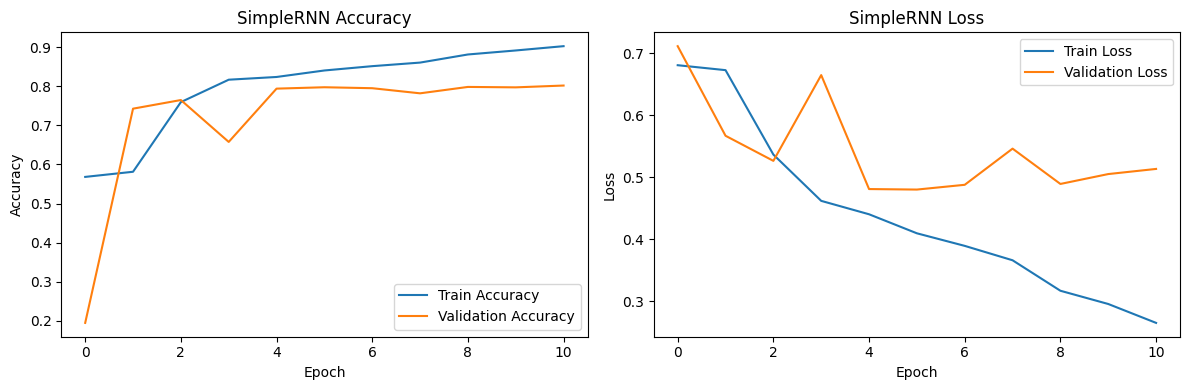

In [22]:
# Train models
print("Training Model 1 (SimpleRNN)...")
history1 = train_model(model1, X_train_resampled, y_train_resampled, X_test_pad, y_test, "SimpleRNN")


Training Model 2 (LSTM)...
Training LSTM with input shapes: X_train=(24148, 254), y_train=(24148,), X_val=(3662, 254), y_val=(3662,)
Epoch 1/30
378/378 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5001 - loss: 0.6939 - val_accuracy: 0.7941 - val_loss: 0.6765 - learning_rate: 0.0010
Epoch 2/30
378/378 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.5049 - loss: 0.6942 - val_accuracy: 0.8105 - val_loss: 0.6681 - learning_rate: 0.0010
Epoch 3/30
378/378 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.5310 - loss: 0.6836 - val_accuracy: 0.7758 - val_loss: 0.4758 - learning_rate: 0.0010
Epoch 4/30
378/378 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.8735 - loss: 0.3441 - val_accuracy: 0.8646 - val_loss: 0.3114 - learning_rate: 0.0010
Epoch 5/30
378/378 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.9325 - loss: 0.2103 - val_accuracy: 0.9044 - val_loss: 0.2449 - learning_rate: 0.0010
Epoch 6/30
378/378 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.9699 - loss: 0.1059 - val_accu

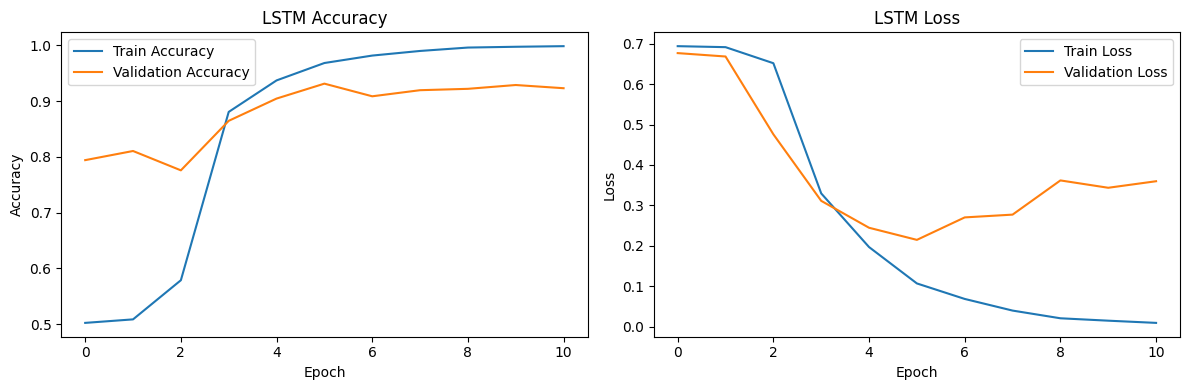

In [23]:
print("\nTraining Model 2 (LSTM)...")
history2 = train_model(model2, X_train_resampled, y_train_resampled, X_test_pad, y_test, "LSTM")

In [24]:
# Load Pre-trained GloVe Embeddings (300-dimensional) for Model 3
print("Loading GloVe embeddings for Model 3...")
try:
    embedding_model = api.load('glove-wiki-gigaword-300')
    embedding_dim = 300
except Exception as e:
    print(f"Error loading GloVe embeddings: {str(e)}")
    exit()

Loading GloVe embeddings for Model 3...


In [25]:
#  Create embedding matrix for Model 3
vocab_size = min(max_words, len(tokenizer.word_index) + 1)
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < vocab_size and word in embedding_model:
        embedding_matrix[i] = embedding_model[word]

In [26]:
# Model 3: LSTM with GloVe Embeddings
model3 = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_len,
              trainable=True),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Sigmoid activation, no extra Dense layer
])

model3.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



Training Model 3 (LSTM with GloVe)...
Training LSTM with GloVe with input shapes: X_train=(24148, 254), y_train=(24148,), X_val=(3662, 254), y_val=(3662,)
Epoch 1/30
378/378 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.5094 - loss: 0.6920 - val_accuracy: 0.8037 - val_loss: 0.6886 - learning_rate: 0.0010
Epoch 2/30
378/378 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.5150 - loss: 0.6894 - val_accuracy: 0.8184 - val_loss: 0.6752 - learning_rate: 0.0010
Epoch 3/30
378/378 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.5612 - loss: 0.6561 - val_accuracy: 0.8727 - val_loss: 0.3760 - learning_rate: 0.0010
Epoch 4/30
378/378 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.8935 - loss: 0.3294 - val_accuracy: 0.8935 - val_loss: 0.3036 - learning_rate: 0.0010
Epoch 5/30
378/378 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9492 - loss: 0.1822 - val_accuracy: 0.8979 - val_loss: 0.2643 - learning_rate: 0.0010
Epoch 6/30
378/378 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.9662 - loss

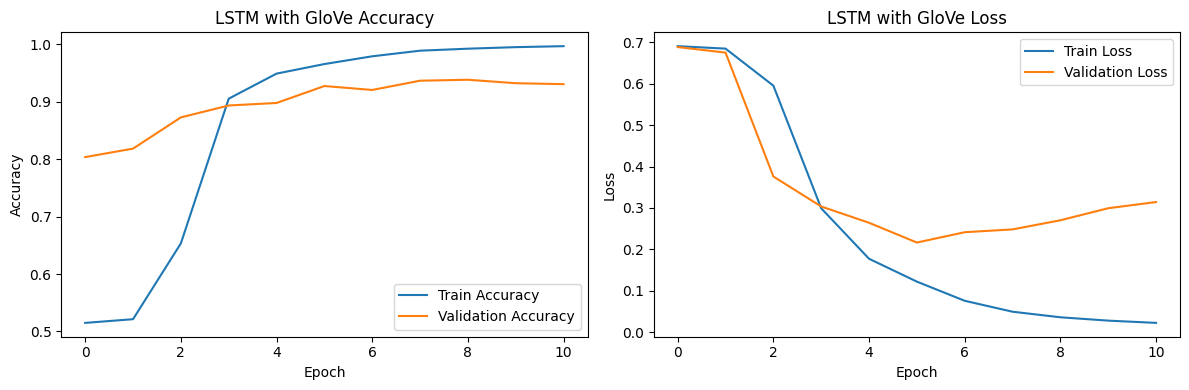

In [27]:
print("\nTraining Model 3 (LSTM with GloVe)...")
history3 = train_model(model3, X_train_resampled, y_train_resampled, X_test_pad, y_test, "LSTM with GloVe")

In [28]:
#  Evaluation function
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    print(f"\n{model_name} Evaluation:")
    acc = accuracy_score(y_test, y_pred) # Calculate accuracy
    print("Accuracy:", acc)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return acc # Return the accuracy

115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

SimpleRNN Evaluation:
Accuracy: 0.7979246313489896

Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.76      0.57       643
           1       0.94      0.81      0.87      3019

    accuracy                           0.80      3662
   macro avg       0.70      0.78      0.72      3662
weighted avg       0.86      0.80      0.82      3662



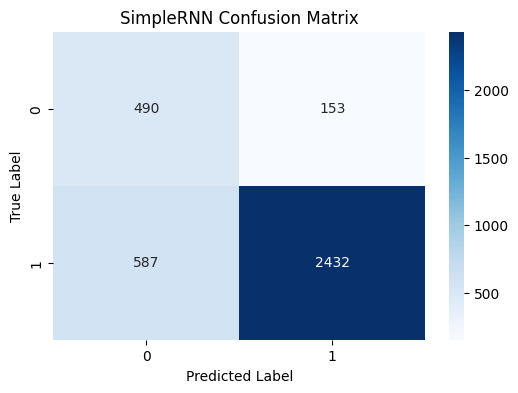

In [29]:
# Evaluate models and collect accuracies
acc1 = evaluate_model(model1, X_test_pad, y_test, "SimpleRNN")

115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

LSTM Evaluation:
Accuracy: 0.931185144729656

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.76      0.79       643
           1       0.95      0.97      0.96      3019

    accuracy                           0.93      3662
   macro avg       0.89      0.86      0.88      3662
weighted avg       0.93      0.93      0.93      3662



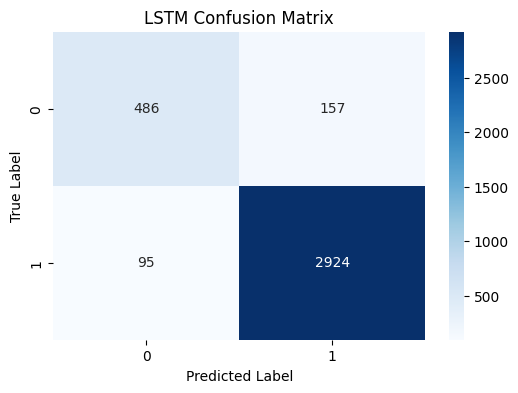

In [30]:
acc2 = evaluate_model(model2, X_test_pad, y_test, "LSTM")

115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

LSTM with GloVe Evaluation:
Accuracy: 0.9273620972146368

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.82      0.80       643
           1       0.96      0.95      0.96      3019

    accuracy                           0.93      3662
   macro avg       0.87      0.89      0.88      3662
weighted avg       0.93      0.93      0.93      3662



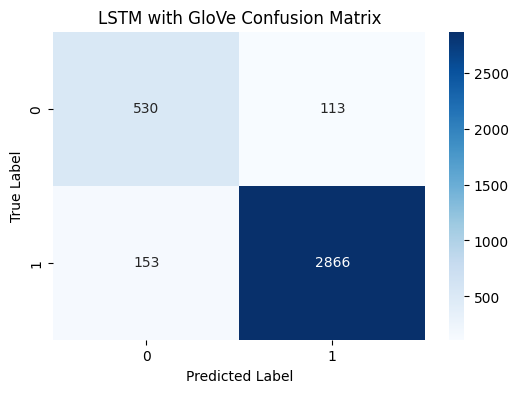

In [31]:
acc3 = evaluate_model(model3, X_test_pad, y_test, "LSTM with GloVe")


Accuracies: {'SimpleRNN': 0.7979246313489896, 'LSTM': 0.931185144729656, 'LSTM with GloVe': 0.9273620972146368}


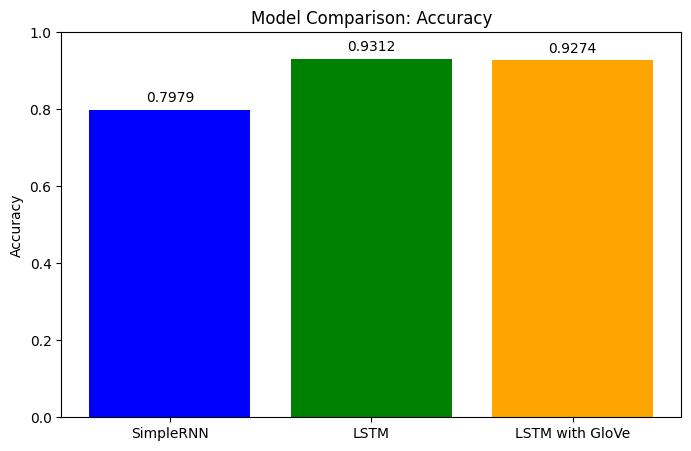

In [32]:
# Debug: Print accuracies to check for None values
print("\nAccuracies:", {"SimpleRNN": acc1, "LSTM": acc2, "LSTM with GloVe": acc3})

# Compare model performances
models = ['SimpleRNN', 'LSTM', 'LSTM with GloVe']
accuracies = [acc1, acc2, acc3]

# Handle None values in accuracies
valid_accuracies = [acc if acc is not None else 0.0 for acc in accuracies]
valid_models = [m for m, acc in zip(models, accuracies) if acc is not None]

if not valid_accuracies:
    print("Error: No valid accuracies to plot. Check model training and evaluation.")
else:
    plt.figure(figsize=(8, 5))
    plt.bar(valid_models, valid_accuracies, color=['blue', 'green', 'orange'])
    plt.title('Model Comparison: Accuracy')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    for i, v in enumerate(valid_accuracies):
        plt.text(i, v + 0.02, f"{v:.4f}", ha='center')
    plt.show()

In [33]:
# Prediction function
def predict_sentiment(review, model_name):
    if not review.strip():
        return "Please enter a review."

    # Clean and preprocess the input review
    cleaned_review = clean_text(review)
    sequence = tokenizer.texts_to_sequences([cleaned_review])
    padded_sequence = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')

    # Select model
    model_dict = {
        "SimpleRNN": model1,
        "LSTM": model2,
        "LSTM with GloVe": model3
    }

    if model_name not in model_dict:
        return "Invalid model selected."

    model = model_dict[model_name]

    # Predict
    prediction = model.predict(padded_sequence, verbose=0)[0][0]
    sentiment = "Positive" if prediction > 0.5 else "Negative"
    confidence = prediction if prediction > 0.5 else 1 - prediction

    return f"Sentiment: {sentiment}\nConfidence: {confidence:.4f}"

In [34]:
# Gradio interface
with gr.Blocks(theme=gr.themes.Soft()) as demo:
    gr.Markdown("## Hotel Review Sentiment Prediction")
    gr.Markdown("Enter a hotel review and select a model to predict whether the sentiment is Positive or Negative.")

    with gr.Row():
        review_input = gr.Textbox(
            label="Hotel Review",
            placeholder="e.g., The hotel was amazing with great service!",
            lines=3
        )

    with gr.Row():
        model_choice = gr.Dropdown(
            choices=["SimpleRNN", "LSTM", "LSTM with GloVe"],
            label="Select Model",
            value="LSTM"
        )

    predict_button = gr.Button("Predict Sentiment")
    output = gr.Textbox(label="Prediction Result", placeholder="Prediction will appear here...")

    predict_button.click(
        fn=predict_sentiment,
        inputs=[review_input, model_choice],
        outputs=output
    )

In [35]:
demo.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://2e6306a049046e3c06.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
